In [1]:
import re
import pandas as pd
import numpy as np

import pprint as pp
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

import xgboost as xgb
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score


import warnings
warnings.filterwarnings("ignore")

# uncomment and run it first!

# import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')

%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
# %%writefile nlp_process_data.py

def build_pipe(vect, model, stopwords=None, ngram_range=(1,1), min_df=3):
    return Pipeline([("count", vect(stop_words=stopwords, ngram_range=ngram_range, 
                                    min_df=min_df)),
                     ("model", model())])

def text_cleaning(series):
    # This func clears text from symbols. 
    # Returns Series -> Series[row] = list of words:str
    for i in range(series.shape[0]):
        text = series.iloc[i]
        pattern = re.compile(r"(?u)\w+")
        series.iloc[i] = re.findall(pattern, text.lower())
    return series

def apply_to_str(data, func):
    # This func applies given func to every word
    # Returns Series -> Series[row] = text:str
    series = data.copy()
    for i in range(data.shape[0]):
        text = series.iloc[i]
        pattern = re.compile(r"(?u)\w+")
        word_list = re.findall(pattern, text.lower())
        series.iloc[i] = " ".join([func(w) for w in word_list])
    return series

def handle_rawdata(X_train, X_test, func=None):
    # Appiles apply_to_str, text_cleaning functions to given Series

    if not func:
        raise AssertionError("No function given!")

    pr_data = list()
    for data in [X_train, X_test]:
        temp = text_cleaning(data)
        pr_data.append(apply_to_str(temp, func))
    return pr_data

def train_test_models(X_train, y_train, cv=3, models_cls=None, vectorizer_cls=None, 
                      random_state=None, min_df=None,stopwords=None, 
                      ngram_range=(1,1), model_names=None, vectorizer_names=None):
    worked_models = list()
    mean = list()
    scores = list()
    
    if not models_cls or not vectorizer_names:
        models_cls = [LogisticRegression,
                      RandomForestClassifier,
                      LinearSVC,
                      SGDClassifier]
        model_names = ["LogReg", "RF Clas.", "LinearSVC", "SGD Clas."]
        
    if not vectorizer_cls or not model_names:
        vectorizer_cls = [TfidfVectorizer, CountVectorizer]
        vectorizer_names = ["TfidfVec", "CntVec"]
       
    _vectorizer_names = iter(vectorizer_names)
    for vectorizer in vectorizer_cls:
        vector_name = _vectorizer_names.__next__()
        _model_names = iter(model_names)
        model_score = list()
        for model in models_cls:
            pipe = build_pipe(vectorizer, model, stopwords=stopwords,
                              ngram_range=ngram_range, min_df=min_df)
            score = cross_val_score(pipe, X_train, y_train, scoring='accuracy',cv=cv)
        
            mean.append(np.mean(score))
            model_score.append(score)
            worked_models.append("{} {}".format(_model_names.__next__(),  vector_name))
        scores.append(model_score)
    return worked_models, mean, scores

In [17]:
path = "/media/winter/vm/github/kaggle/Product_Sentiment/"
kagle_data = open(path+"test.csv", "r").readlines()

kagle_data = " ".join(kagle_data).split("</review>")[:-1]
X_kaggle_raw = pd.Series([text.replace('<review>', "").replace("\n", "") for text in kagle_data])

stop_words = stopwords.words('russian')

data = pd.read_csv("phone_reviews_final.csv", sep=',', header=0, names=['index','mark','rev'])
data.drop('index', axis=1, inplace=True)


print(data.shape)
print(data['mark'].value_counts())

(10709, 2)
1.0    8458
0.0    2251
Name: mark, dtype: int64


Because of unevenness of frequencies 1:8458 and 0:2251  
I'm going to use class_weights to balance weights of 0 marked revies by 3 

In [19]:
# Override
def handle_rawdata(X_train, X_test, X_kaggle, func):
    pr_data = list()
    for data in [X_train, X_test, X_kaggle]:
        pr_data.append(apply_to_str(text_cleaning(data), func))
    return pr_data
"""
WordNetLemmatizer().lemmatize
SnowballStemmer('russian').stem
PorterStemmer().stem
"""
X_train, X_test = train_test_split(data['rev'].copy(), random_state=42)
y_train, y_test = train_test_split(data['mark'].copy(), random_state=42)

X_train, X_test, X_kaggle = handle_rawdata(X_train,X_test, X_kaggle_raw.copy(), PorterStemmer().stem)
X_full = X_train.append(X_test)
y_full = data['mark']

In [ ]:
multi_model = train_test_models(data['rev'],data['mark'], min_df=3, ngram_range=(1,3))
multi_model

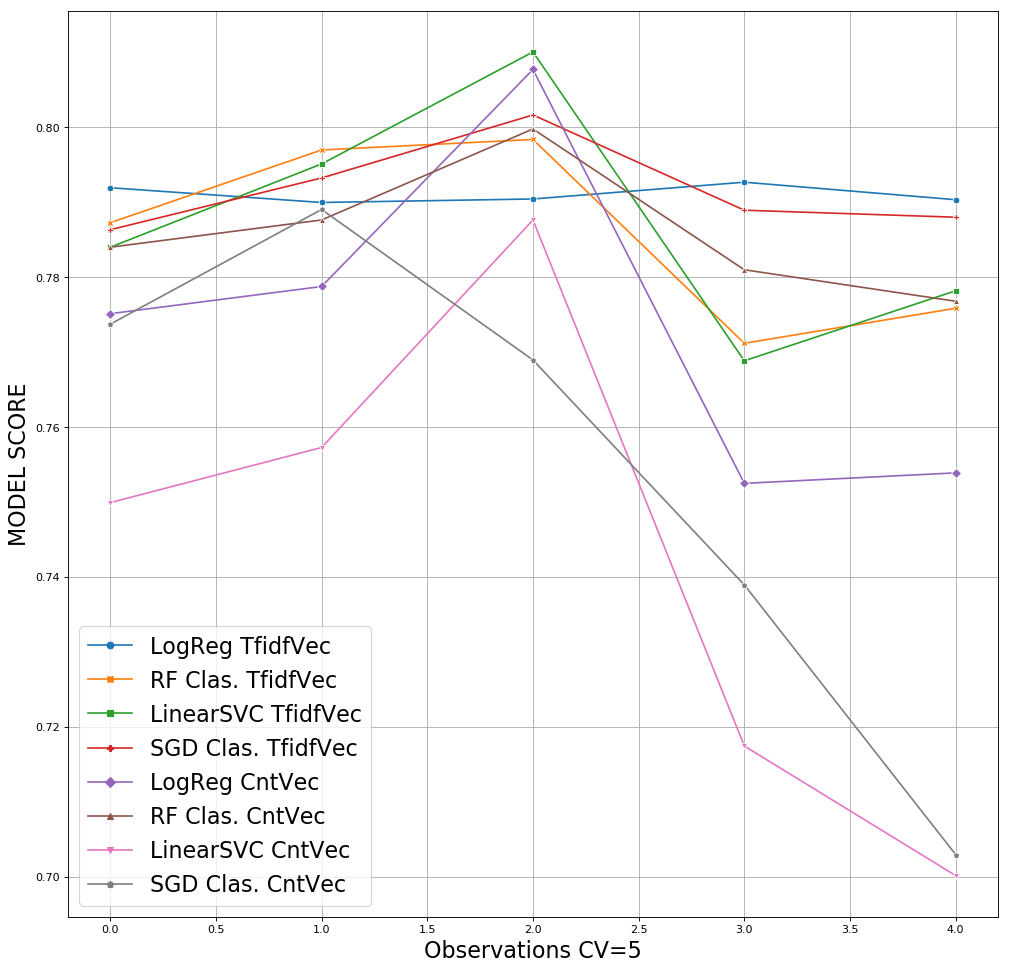

In [98]:
names_ =  multi_model[0]
scores_ = [i for j in multi_model[2] for i in j]
plt.figure(dpi=80, figsize=(15,15))
sns.lineplot(data= pd.DataFrame(dict(zip(names_,scores_))),dashes=False,markers=True,
             size=np.array([2 for i in range(0,8)]))
plt.xlabel("Observations CV=5", fontsize=20)
plt.ylabel("MODEL SCORE", fontsize=20)
plt.grid(True)
plt.legend(fontsize=20)

In [38]:
# I gave x3 to 0 class to balance classes
model = LogisticRegression(penalty='l2', C=1,
                           class_weight={0:3, 1:1}, solver='liblinear', n_jobs=-1)
vectorizer = CountVectorizer(ngram_range=(1,3), min_df=3)

X_train_, X_test_, X_kaggle_ = X_train.copy(), X_test.copy(), X_kaggle.copy()

vectorizer.fit(X_train_)
X_train_ = vectorizer.transform(X_train_)
model.fit(X_train_, y_train)

X_test__ = vectorizer.transform(X_test_)
model_pred = model.predict(X_test__)

model_acc = accuracy_score(y_test, model_pred)
print("model score: ", model_acc)
print("vocab capacity:",len(vectorizer.vocabulary_))

model score:  0.7733383121732637
vocab capacity: 104344


In [27]:
# Let see most valuable word in our model
coef = model.coef_.tolist()[0]
most_valuable_features = [coef.index(i) for i in sorted(coef)[:100]]
features = np.array(vectorizer.get_feature_names())

mvf = features[most_valuable_features]
mvf_cnt = [vectorizer.vocabulary_.get(i) for i in mvf]

most_valuable_words = sorted(list(zip(mvf, mvf_cnt)), key=lambda tup: tup[1], reverse=True)
mvf

array(['ужасно', 'итоге', 'разблокировки', 'крупные', 'невозможно',
       'фоне', 'другого', 'постоянно', 'разы', 'второй', 'тоже не',
       'искал', 'конкретно', 'которые', 'рублей', 'покупать', 'плата',
       'память', 'перезагрузка', 'внешний', 'экран тоже', 'одно',
       'не советую', 'порой', 'фотографировать', 'его не', 'полное',
       'глючит', 'большие', 'брать', 'конечно но', 'жутко', 'отцу',
       'заряжается', 'пол дня', 'первое', 'тд', 'внешне', 'пока работает',
       'хорош', 'завышена цена', 'начал', 'только на', 'ощущение',
       'работает отлично', 'аккумулятор', 'нереально', 'мп', 'кусок',
       'игры', 'заряд батареи', 'тихий', 'не рекомендую', 'сам',
       'ожидания', '3d', 'показывает', 'непонятно', 'данный', 'завышена',
       'падении', 'жизни', 'не помогают', 'него не', '70', 'чего',
       'дважды', 'был', 'изображение', 'день', 'недостаточно',
       'информации', 'опять', 'потом', 's7', 'фронтальная камера',
       'выпал', 'очень тихий', 'оригинальн

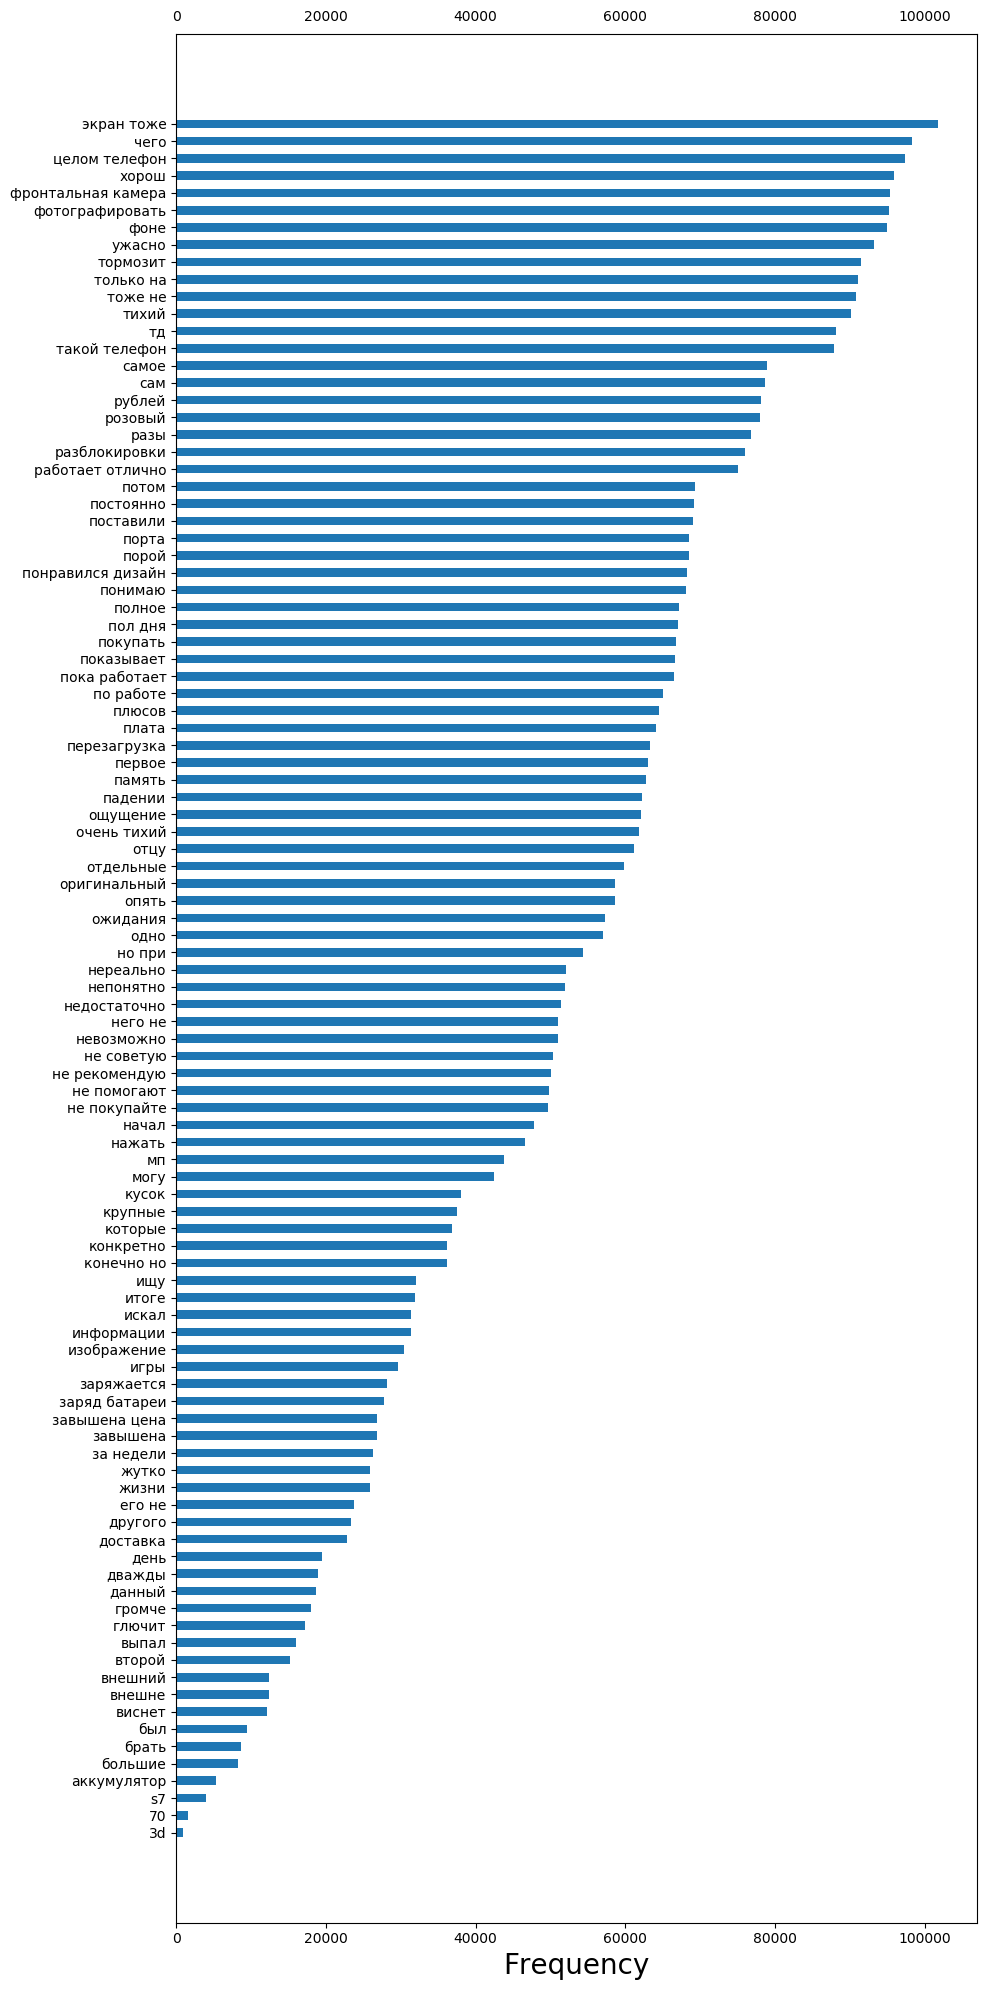

In [31]:
x_,y_ = zip(*most_valuable_words)

plt.figure(figsize=(10,20), dpi=100)
plt.barh(x_[::-1], y_[::-1], height=0.5)
plt.xlabel('Frequency', fontsize=20)
plt.tick_params(labelbottom='on',labeltop='on')
plt.tight_layout()
plt.show()

As we can see there are a lot of useless words such as 'чего', 'потом', 'тд', 'порой'.  
But in predicting models with text as input most of the times stop_words can be most valueble  
  
My subjective  explain is what  mood of the writer to write good or bad review can cause a lot of   stop_words and vice versa.  
  
Removing stop_words makes model less effective on a test dataset.  

In [36]:
sub_predict = ['pos' if i else 'neg' for i in model.predict(vectorizer.transform(X_kaggle_))]
submit = pd.DataFrame({'y':sub_predict})
submit.index.name='id'
submit.to_csv("submission.csv", sep=',')

In [37]:
submit['y'].value_counts()

pos    51
neg    49
Name: y, dtype: int64

In [13]:
# # Cross validation score
# model = LogisticRegression(penalty='l2', C=0.1,
#                            class_weight={0:3, 1:1}, solver='liblinear', n_jobs=3)
# vectorizer = CountVectorizer(ngram_range=(1,3), min_df=3)

# pipe = Pipeline([("vectorizer", vectorizer), ("model", model)])


# cross_acc = cross_val_score(pipe, full_fp, full_mark, scoring='accuracy', cv=5)
# print("cross score: ", cross_acc,"mean: ", np.mean(cross_acc))

cross score:  [0.74475035 0.77684407 0.79551821 0.72909855 0.70667912] mean:  0.7505780604410838


In [15]:
# grid_params = {"C":np.logspace(-4, 4, 20),
#               "solver":["lbfgs", "saga", "sag", "liblinear"],
#               "class_weight":[{0:1.5, 1:1}, {0:2, 1:1}, {0:1, 1:1}],
#               "intercept_scaling":[1,2,4, 0.5]}
# grid_model = GridSearchCV(cv=5, estimator=LogisticRegression(), 
#                           param_grid=grid_params, scoring='accuracy', n_jobs=3)

# grid_model.fit(X_train__, y_train)
# grid_pred = grid_model.predict(X_test__)

In [ ]:
# grid_model.best_score_

In [ ]:
# grid_model.best_estimator_